# House Prices — Kernel Methods & Tree Models

_Note: Cleared the output of some cells to reduce file size. The full output can be viewed [here](https://www.kaggle.com/code/chongzhenjie/house-prices-kernel-methods-tree-models)._

Below is a summary of the approach I have taken in this notebook.

**Data Preprocessing:**
- This section mainly deals with filling the missing values in the data. A number of columns have categories NA/None to denote that the corresponding feature of the house does not exist. It could be possible that the feature exists, but there are actual missing data values. To differentiate between the two cases, I give an example using the basement feature. If its corresponding columns `BsmtQual`, `BsmtFinSF1`, `BsmtFullBath`, etc. are all filled with 0 or NA, I assume that the particular house does not have a basement, and fill using the value 0 or string "NA" accordingly.
- After the first round of imputation, we still have missing values for the columns filled from the process described above, indicating that the data values are indeed missing. We fill the remaining values using some form of estimation. In particular, the log values of `LotFrontage` and `LotArea` are strongly correlated, so it is reasonable to fill the missing values using regression.
- To keep things simple, the remaining columns with about 1-4 missing values each are filled using median/mode imputation.

**Feature Engineering:**
- [Statistical tests](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html) (F-test statistics and mutual information) are used to help feature selection. These are univariate tests so they do not take into account any interaction effects between the features, but they are simpler to understand and less computationally expensive than building models.
- Thresholds are not set, but generally columns that have one dominant value, perform poorly in the statistical tests, or give similar information to other columns (e.g. `GarageCars` vs. `GarageArea`) are all dropped. 
- The usual feature creation/transformation and ordinal/one-hot encoding are performed.

**Model Training:**
- All models are implemented using sklearn. In particular, linear models (Ridge and LinearSVR) are used as benchmarks. The main models are kernel methods (KernelRidge and SVR) and tree models (RandomForest and GradientBoostingRegressor).
- A final ensemble model, which is the average of KernelRidge, SVR, and GradientBoostingRegressor, is used for submission.

**Other things not looked at:**
- Outlier handling — my local cv results greatly improved by removing or reducing the impact of outliers, but the LB results did not improve.
- Other established feature selection/dimensionality reduction tools.
- Other ensemble techniques like stacking.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid", font_scale=1.2)
import matplotlib.pyplot as plt
from scipy.stats import probplot

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

from data_processing import(
    extract_data_descr, check_missing_values, fill_with_constant, 
    fill_with_estimate, dummy_encoder, RegressionImputer, SEED,
)
from plot import regplot, multi_regplot, multi_catplot
from model_tuner import rmse_loss, ModelTuner

---

# 1. Loading Datasets

In [2]:
data_descr = extract_data_descr("data/data_description.txt")

print(data_descr)

{'MSSubClass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190'], 'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'], 'LotFrontage': [], 'LotArea': [], 'Street': ['Grvl', 'Pave'], 'Alley': ['Grvl', 'Pave', 'NA'], 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'], 'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'], 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], 'LandSlope': ['Gtl', 'Mod', 'Sev'], 'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'], 'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'BldgType': ['1Fam', '2FmCo

In [3]:
X_train = pd.read_csv("data/train.csv").drop(columns=["Id"])
X_test = pd.read_csv("data/test.csv").drop(columns=["Id"])

y_train = X_train.pop("SalePrice")

---

# 2. Data Preprocessing

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

From the information of the dataframe above, many columns have missing values, and some columns may have their dtypes incorrectly labeled.

### Columns with incorrect dtypes.

Some columns have categories consisting of integers, resulting in them being recognized as numerical. We assign them back as objects. Date columns (concerning the year and month) are also usually categorical.

In [5]:
INCORRECT_DTYPE = [
    key for key, val in data_descr.items()
    if val and np.issubdtype(X_train[key], np.number)
]
DATE_COL = [
    col for col in X_train.columns
    if any(date in col for date in ["Mo", "Yr", "Year"])
]
INCORRECT_DTYPE.extend(DATE_COL)
print(INCORRECT_DTYPE)

X_train[INCORRECT_DTYPE] = X_train[INCORRECT_DTYPE].astype(object)
X_test[INCORRECT_DTYPE] = X_test[INCORRECT_DTYPE].astype(object)

['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']


### Columns with missing values.

In [6]:
check_missing_values(X_train, X_test)

(TRAIN) Number of missing values:
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
(TEST) Number of missing values:
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish     

From the data description text file, some columns have NA categories to denote that a particular element of the house does not exist (e.g. no garage). We check below that none of the data contains the string "NA", so the NA categories are most likely recognized as NaN values.

In [7]:
print((X_train=="NA").sum().sum())
print((X_test=="NA").sum().sum())

0
0


On the other hand, it is possible that some houses have the features, but data is indeed missing. To differentiate between the two cases, we check that all related columns (of `Bsmt`, `MasVnr`, etc.) are indeed 0/NA values, indicating that the corresponding feature most likely does not exist for the house. For features with single columns (like `Alley` and `Fence`), we just fill the missing values straight.

For numerical columns, we fill using the value 0. For categorical columns, we use the string "NA".

In [8]:
HSE_FEAT = ["Bsmt", "MasVnr", "Pool", "Fireplace", "Misc", "Garage"]

RELATED_COL = {
    feat: [col for col in X_train if feat in col]
    for feat in HSE_FEAT
}

print("="*40)
print("Columns to fill missing values:")
print("="*40)
print(RELATED_COL)

Columns to fill missing values:
{'Bsmt': ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'], 'MasVnr': ['MasVnrType', 'MasVnrArea'], 'Pool': ['PoolArea', 'PoolQC'], 'Fireplace': ['Fireplaces', 'FireplaceQu'], 'Misc': ['MiscFeature', 'MiscVal'], 'Garage': ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']}


In [9]:
X_train[["Alley", "Fence"]] = X_train[["Alley", "Fence"]].fillna("NA")
X_test[["Alley", "Fence"]] = X_test[["Alley", "Fence"]].fillna("NA")

for cols in RELATED_COL.values():
    X_train, X_test = fill_with_constant(X_train, X_test, cols)
    
X_train.MasVnrType = X_train.MasVnrType.replace({"None": "NA"})
X_test.MasVnrType = X_test.MasVnrType.replace({"None": "NA"})

Instead of filling the missing values in `GarageYrBlt` column with "NA", we fix them to the values of the `YearBuilt` column. The reason is that the date columns can be used to create useful numerical features later, so this will be a possible approximation.

In [10]:
fill_GarageYrBlt_fn = lambda x: x.YearBuilt if pd.isna(x.GarageYrBlt) else x.GarageYrBlt

X_train.GarageYrBlt = X_train.apply(fill_GarageYrBlt_fn, axis=1).astype(object)
X_test.GarageYrBlt = X_test.apply(fill_GarageYrBlt_fn, axis=1).astype(object)

In [11]:
check_missing_values(X_train, X_test)

(TRAIN) Number of missing values:
LotFrontage     259
BsmtExposure      1
BsmtFinType2      1
Electrical        1
dtype: int64
(TEST) Number of missing values:
MSZoning          4
LotFrontage     227
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType        1
BsmtQual          2
BsmtCond          3
BsmtExposure      2
KitchenQual       1
Functional        2
GarageFinish      2
GarageCars        1
GarageArea        1
GarageQual        2
GarageCond        2
PoolQC            3
MiscFeature       1
SaleType          1
dtype: int64


We still have missing values after the first round of imputation. Without any other information, we can only fill the remaining values using some form of estimation.

### Fill using estimated values.

`LotFrontage` has the largest number of missing values among the remaining columns. In general, we can expect that houses with large `LotFrontage` would also have large `LotArea`. We can verify this with the regression plot below.

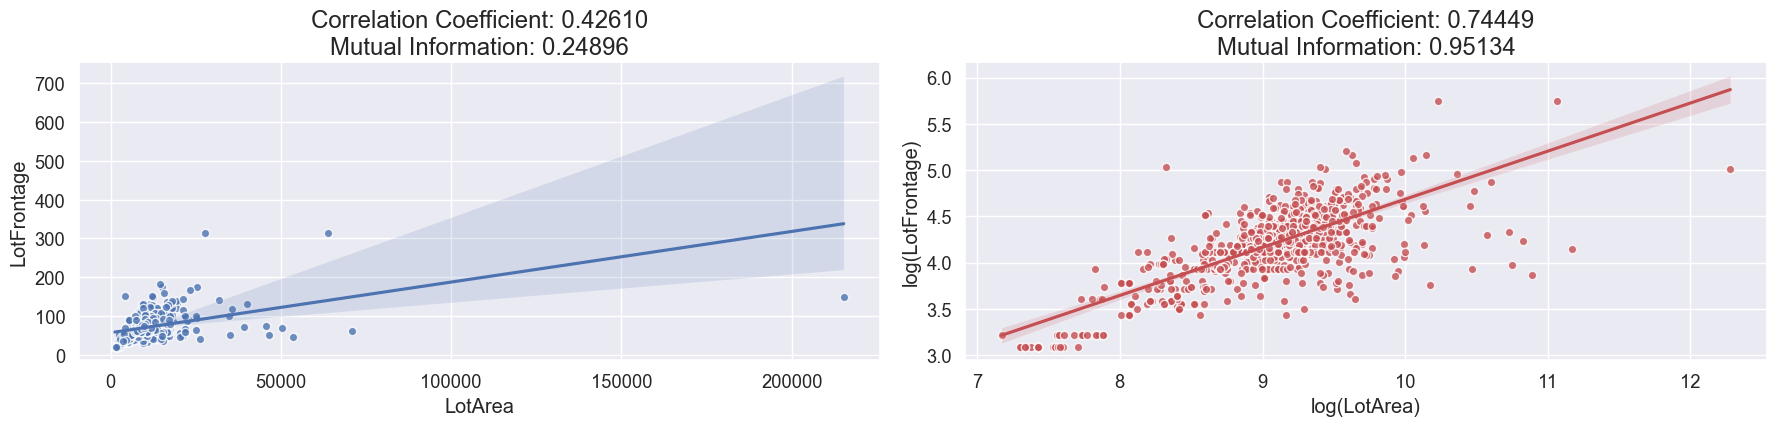

In [12]:
plt.figure(figsize=(18, 4.5))

plt.subplot(121)
regplot(X_train.LotArea, X_train.LotFrontage, remove_na=True)

plt.subplot(122)
regplot(np.log1p(X_train.LotArea), np.log1p(X_train.LotFrontage), remove_na=True, color="r")
plt.xlabel("log(LotArea)")
plt.ylabel("log(LotFrontage)")

plt.show()

Using a log-log plot to reduce the effect of outlier values, we see that the log of the two columns are strongly correlated. We impute the missing values in `LotFrontage` using regression on the log values.

In [13]:
imputer = RegressionImputer(RidgeCV())
imputer.fit(X_train.LotArea, X_train.LotFrontage)

X_train.LotFrontage = imputer.transform(X_train.LotArea, X_train.LotFrontage)
X_test.LotFrontage = imputer.transform(X_test.LotArea, X_test.LotFrontage)

To keep things simple, we fill the remaining missing values by computing the median/mode over the training data. We recall that the 0/"NA" values imputed earlier indicate that the house does not have the corresponding feature, so we need to exclude these houses for the estimations to be more representative of other houses that have such features. 

To give an example, we use `PoolQC` with 3 missing values left in the testing data. These 3 houses have `PoolArea` greater than 0, indicating that the houses have pools. However, the mode of `PoolQC` over the training data is "NA", which is a contradiction. Hence, we first remove houses without pools and then compute the mode. The same applies for other features with multiple related columns.

In [14]:
X_train, X_test = fill_with_estimate(X_train, X_test, related_col=RELATED_COL)

In [15]:
check_missing_values(X_train, X_test)

(TRAIN) Number of missing values:
Series([], dtype: int64)
(TEST) Number of missing values:
Series([], dtype: int64)


---

# 3. Feature Engineering

In [16]:
pd.concat(
    [X_train.describe().T.add_prefix("tr_"),X_test.describe().T.add_prefix("tt_")],
    axis=1,
).drop(columns=["tr_count", "tt_count"])

,tr_mean,tr_std,tr_min,tr_25%,tr_50%,tr_75%,tr_max,tt_mean,tt_std,tt_min,tt_25%,tt_50%,tt_75%,tt_max
LotFrontage,71.176994,25.668941,21.0,60.00,70.0,80.00,313.0,69.419272,22.057460,21.0,60.0,68.232044,80.0,200.0
LotArea,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0,9819.161069,4955.517327,1470.0,7391.0,9399.000000,11517.5,56600.0
MasVnrArea,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0,99.673749,177.001792,0.0,0.0,0.000000,162.0,1290.0
BsmtFinSF1,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0,438.902673,455.257119,0.0,0.0,350.000000,752.0,4010.0
BsmtFinSF2,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0,52.583276,176.698671,0.0,0.0,0.000000,0.0,1526.0
BsmtUnfSF,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0,553.915010,437.351324,0.0,219.0,460.000000,797.5,2140.0
TotalBsmtSF,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0,1045.400960,443.592976,0.0,784.0,988.000000,1304.0,5095.0
1stFlrSF,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0,1156.534613,398.165820,407.0,873.5,1079.000000,1382.5,5095.0
2ndFlrSF,346.992466,436.528436,0.0,0.00,0.0,728.00,2065.0,325.967786,420.610226,0.0,0.0,0.000000,676.0,1862.0
LowQualFinSF,5.844521,48.623081,0.0,0.00,0.0,0.00,572.0,3.543523,44.043251,0.0,0.0,0.000000,0.0,1064.0


From the statistics of the numerical columns, we observe the following:
* Skewed distributions as indicated by the large differences between the maximum and the 75th percentile.
* Columns of different scales.

In [17]:
pd.concat(
    [X_train.describe(include=object).T.add_prefix("tr_"), X_test.describe(include=object).T.add_prefix("tt_")],
    axis=1,
).drop(columns=["tr_count", "tt_count"])

,tr_unique,tr_top,tr_freq,tt_unique,tt_top,tt_freq
MSSubClass,15,20,536,16,20,543
MSZoning,5,RL,1151,5,RL,1118
Street,2,Pave,1454,2,Pave,1453
Alley,3,NA,1369,3,NA,1352
LotShape,4,Reg,925,4,Reg,934
LandContour,4,Lvl,1311,4,Lvl,1311
Utilities,2,AllPub,1459,1,AllPub,1459
LotConfig,5,Inside,1052,5,Inside,1081
LandSlope,3,Gtl,1382,3,Gtl,1396
Neighborhood,25,NAmes,225,25,NAmes,218


From the statistics of the categorical columns, we note the following: 
* Many columns like `PoolQC` and `Utilities` have dominant categories that take up most of the observations.
* Many columns have a lot of unique categories.

Before moving on, we can check that the maximum `GarageYrBlt` for the testing data is 2207, which is most likely mislabeled.

In [18]:
X_test[X_test.GarageYrBlt==X_test.GarageYrBlt.max()][DATE_COL]

,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold
1132,2006,2007,2207.0,9,2007


Judging from the other date columns, we make a guess that the correct value is most likely 2007.

In [19]:
X_test.loc[X_test.GarageYrBlt==2207, "GarageYrBlt"] = 2007

### Ordinal encoding.

There are a number of columns with natural ordered categories, like `OverallQual` ranging from 1 (Very Poor) to 10 (Very Excellent). The data description text file has the categories sorted in order already. We make use of the this to perform ordinal encoding to make analysis easier.

In [20]:
# ordinal columns manually selected
ORDINAL_COL = [
    "LotShape", "LandContour", "Utilities", "LandSlope", "OverallQual",
    "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "Electrical",
    "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", 
    "GarageCond", "PavedDrive", "PoolQC", "Fence",
]

ORDINAL_CAT = [
    val[::-1] for key, val in data_descr.items()
    if key in ORDINAL_COL
]

print(ORDINAL_CAT)

[['IR3', 'IR2', 'IR1', 'Reg'], ['Low', 'HLS', 'Bnk', 'Lvl'], ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], ['Sev', 'Mod', 'Gtl'], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['NA', 'No', 'Mn', 'Av', 'Gd'], ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['NA', 'Unf', 'RFn', 'Fin'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['N', 'P', 'Y'], ['NA', 'Fa', 'TA', 'Gd', 'Ex'], ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']]


In [21]:
ordinal_enc = OrdinalEncoder(categories=ORDINAL_CAT)
X_train[ORDINAL_COL] = ordinal_enc.fit_transform(X_train[ORDINAL_COL].astype(str))
X_test[ORDINAL_COL] = ordinal_enc.transform(X_test[ORDINAL_COL].astype(str))

### Feature creation and transformation.

We look at creating/transforming features in the following sections to convey more useful information. To better support our analysis, we use statistical tests to determine whether or not the feature is relevant to our models. In particular, we use the Pearson's correlation coefficient/F-test statistics to measure linear correlation, and mutual information to capture nonlinear behavior. We note that these are univariate tests so they do not take into account any interaction effects between the features.

Due to large number of columns in the data, we look at each group of features separately in each section. At the beginning of each section we provide a summary of the following:
* __Features transformed__ — generally involves reducing the number of categories in each feature.

* __Features added__ — new features created from existing features and the reasoning behind it.

* __Features removed__ — feature has one dominant value, performs poorly in the univariate statistical tests, or provides similar information to other features.

### Target column: `SalePrice`.

The target column seems to follow a log-normal distribution. We consider using the log of `SalePrice` instead so that the errors in predicting cheap and expensive houses are more even. Predicting log of `SalePrice` (which now takes both positive and negative values) also make certain models like linear regression viable. This is supported by the normal Q-Q plot below.

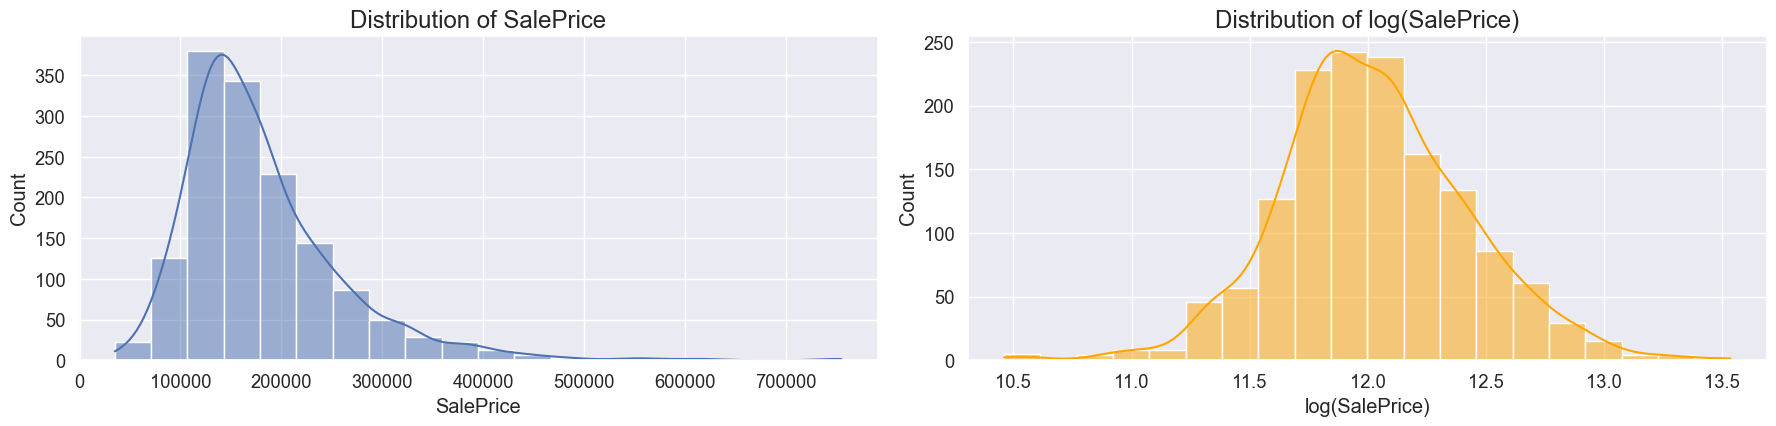

In [22]:
plt.figure(figsize=(18, 4.5))

plt.subplot(121)
sns.histplot(y_train, bins=20, kde=True)
plt.title("Distribution of SalePrice", fontsize="large")

plt.subplot(122)
sns.histplot(np.log1p(y_train), bins=20, kde=True, color="orange")
plt.xlabel("log(SalePrice)")
plt.title("Distribution of log(SalePrice)", fontsize="large")

plt.tight_layout()
plt.show()

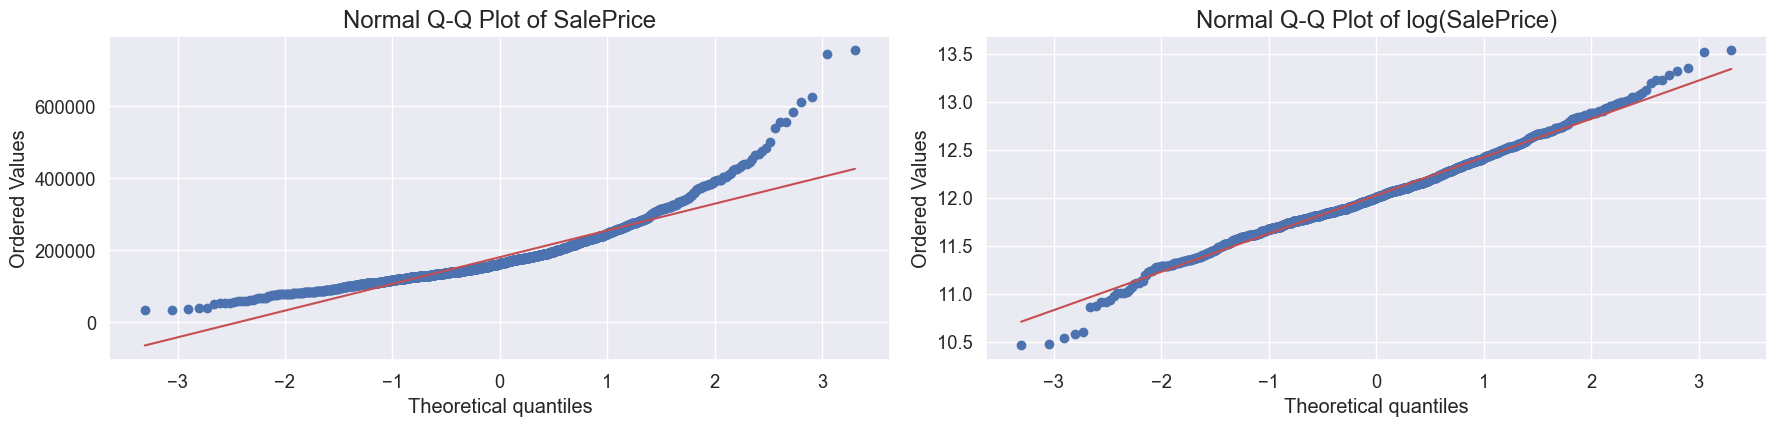

In [23]:
fig = plt.figure(figsize=(18, 4.5))

ax = fig.add_subplot(121)
probplot(y_train, plot=ax)
plt.title("Normal Q-Q Plot of SalePrice", fontsize="large")

ax = fig.add_subplot(122)
probplot(np.log1p(y_train), plot=ax)
plt.title("Normal Q-Q Plot of log(SalePrice)", fontsize="large")

plt.tight_layout()
plt.show()

In [24]:
y_train = np.log1p(y_train).rename("LogSalePrice")

### Date features.

__Features transformed__
* None.

__Features added__
* (`BltToSold`, `RemodToSold`, `GrgBltToSold`) — computed by taking the difference between `YrSold` and each of (`YearBuilt`, `YearRemodAdd`, `GarageYrBlt`) respectively. We expect that newer houses or houses that are recently remodeled are more expensive. The same applies for newer garages.

* `SeasSold` — computed by grouping the months into the corresponding seasons: spring, summer, autumn, winter. We expect that house sales may have seasonal patterns, and this also helps reduce the number of categories.

__Features removed__
* `YearBuilt`, `YearRemodAdd`, `GarageYrBlt`, `MoSold`, `SeasSold`, `YrSold`.

In [ ]:
YR_COL = ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]
RENAME_YR = {
    "YearBuilt": "BltToSold",
    "YearRemodAdd": "RemodToSold",
    "GarageYrBlt": "GrgBltToSold",
}

X_train[YR_COL] = (-X_train[YR_COL].sub(X_train.YrSold, axis=0)).astype(float)
X_test[YR_COL] = (-X_test[YR_COL].sub(X_test.YrSold, axis=0)).astype(float)

X_train = X_train.rename(columns=RENAME_YR)
X_test = X_test.rename(columns=RENAME_YR)

multi_regplot(X_train, y_train, cols=RENAME_YR.values())

In [ ]:
def month_to_season(mth):
    assert mth>=0 and mth<=12
    if mth==12 or mth<=2:
        return "winter"
    elif mth<=5:
        return "spring"
    elif mth<=8:
        return "summer"
    else:
        return "autumn"

In [ ]:
X_train["SeasSold"] = X_train.MoSold.apply(month_to_season)
X_test["SeasSold"] = X_test.MoSold.apply(month_to_season)

multi_catplot(X_train, y_train, cols=["MoSold", "SeasSold"])

In [ ]:
X_train = X_train.drop(columns=["MoSold", "SeasSold"], errors="ignore")
X_test = X_test.drop(columns=["MoSold", "SeasSold"], errors="ignore")

In [ ]:
multi_catplot(X_train, y_train, cols=["YrSold"])

In [ ]:
X_train = X_train.drop(columns=["YrSold"], errors="ignore")
X_test = X_test.drop(columns=["YrSold"], errors="ignore")

### Outdoor area features.

__Features transformed__
* None.

__Features added__
* `OutArea` — computed by summing (`OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, `ScreenPorch`, `WoodDeckSF`) to indicate the total outdoor area of the house.

* `NumOutType` — computed by counting how many of each (`OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, `ScreenPorch`, `WoodDeckSF`) are greater than 0. This is an alternative to `OutArea`; instead of looking at the exact area, we count the types of outdoor structures the house has.

* (`HasOpenPorch`, `HasEnclosedPorch`, `Has3SsnPorch`, `HasScreenPorch`, `HasWoodDeck`) — indicator columns for each of (`OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, `ScreenPorch`, `WoodDeckSF`) respectively.

__Features removed__
* `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, `ScreenPorch`, `WoodDeckSF`, `Has3SsnPorch`.

In [ ]:
OUT_COL = [col for col in X_train.columns if "Porch" in col] + ["WoodDeckSF"]
print(OUT_COL)

X_train["OutArea"] = X_train[OUT_COL].sum(axis=1)
X_test["OutArea"] = X_test[OUT_COL].sum(axis=1)

multi_regplot(X_train, y_train, cols=OUT_COL+["OutArea"])

In [ ]:
X_train["NumOutType"] = (X_train[OUT_COL]>0).sum(axis=1)
X_test["NumOutType"] = (X_test[OUT_COL]>0).sum(axis=1)

multi_catplot(X_train, y_train, cols=["NumOutType"])

In [ ]:
OUT_REPLACE = {
    "OpenPorchSF": "HasOpenPorch",
    "EnclosedPorch": "HasEnclosedPorch",
    "3SsnPorch": "Has3SsnPorch",
    "ScreenPorch": "HasScreenPorch",
    "WoodDeckSF": "HasWoodDeck",
}

X_train[OUT_COL] = (X_train[OUT_COL]>0).replace({True: "Yes", False: "No"})
X_test[OUT_COL] = (X_test[OUT_COL]>0).replace({True: "Yes", False: "No"})

X_train = X_train.rename(columns=OUT_REPLACE)
X_test = X_test.rename(columns=OUT_REPLACE)

multi_catplot(X_train, y_train, cols=OUT_REPLACE.values())

In [ ]:
X_train = X_train.drop(columns=["Has3SsnPorch"], errors="ignore")
X_test = X_test.drop(columns=["Has3SsnPorch"], errors="ignore")

### Pool features.

__Features transformed__
* None.

__Features added__
* None.

__Features removed__
* `PoolArea`, `PoolQC`.

In [ ]:
multi_regplot(X_train, y_train, cols=["PoolArea"])
multi_catplot(X_train, y_train, cols=["PoolQC"])

In [ ]:
X_train = X_train.drop(columns=["PoolArea", "PoolQC"], errors="ignore")
X_test = X_test.drop(columns=["PoolArea", "PoolQC"], errors="ignore")

### Indoor area features.

It is worth noting that `TotalBsmtSF`=`BsmtFinSF1`+`BsmtFinSF2`+`BsmtUnfSF` and `GrLivArea`=`1stFlrSF`+`2ndFlrSF`+`LowQualFinSF`.

__Features transformed__
* None.

__Features added__
* (`Has2ndFlr`, `HasBsmt`) — indicator columns for each of (`2ndFlrSF`, `TotalBsmtSF`) respectively.

__Features removed__
* `BsmtFinSF2`, `LowQualFinSF`.

In [ ]:
IN_COL = [col for col in X_train if "SF" in col and not col in OUT_COL] + ["GrLivArea"]
print(IN_COL)

multi_regplot(X_train, y_train, cols=IN_COL)

In [ ]:
X_train["Has2ndFlr"] = X_train["2ndFlrSF"].apply(lambda x: "Yes" if x>0 else "No")
X_test["Has2ndFlr"] = X_test["2ndFlrSF"].apply(lambda x: "Yes" if x>0 else "No")

X_train["HasBsmt"] = X_train.TotalBsmtSF.apply(lambda x: "Yes" if x>0 else "No")
X_test["HasBsmt"] = X_test.TotalBsmtSF.apply(lambda x: "Yes" if x>0 else "No")

multi_catplot(X_train, y_train, cols=["Has2ndFlr", "HasBsmt"])

In [ ]:
X_train = X_train.drop(columns=["BsmtFinSF2", "LowQualFinSF"], errors="ignore")
X_test = X_test.drop(columns=["BsmtFinSF2", "LowQualFinSF"], errors="ignore")

### Other basement features.

__Features transformed__
* None.

__Features added__
* None.

__Features removed__
* None.

In [ ]:
BSMT_COL = [
    col for col in X_train.columns 
    if (not col in IN_COL+["HasBsmt"])
    and ("Bsmt" in col)
    and (not "Bath" in col)
]
print(BSMT_COL)

multi_catplot(X_train, y_train, BSMT_COL)

### Bathroom features.

__Features transformed__
* None.

__Features added__
* (`TtlFullBath`, `TtlHalfBath`) — computed by summing (`FullBath`, `BsmtFullBath`) and (`HalfBath`, `BsmtHalfBath`) respectively.

* `TtlBath` — computed by summing `TtlFullBath` and `TtlHalfBath`. We multiply 0.5 to `TtlHalfBath` because full bathrooms and half bathrooms are fundamentally different. This acts as an approximation.

* `HasHalfBath` — indicator column for `TtlHalfBath`. Having half bathrooms may be seen as additional feature that is good to have in a house.

* `HasBsmtBath` — indicator column computed by checking if the sum of (`BsmtFullBath`, `BsmtHalfBath`) is greater than 0. Similarly, this may be seen as an additional feature.

__Features removed__
* `BsmtFullBath`, `BsmtHalfBath`.

In [ ]:
FULLBATH_COL = ["FullBath", "BsmtFullBath"]
HALFBATH_COL = ["HalfBath", "BsmtHalfBath"]

X_train["TtlFullBath"] = X_train[FULLBATH_COL].sum(axis=1)
X_test["TtlFullBath"] = X_test[FULLBATH_COL].sum(axis=1)

X_train["TtlHalfBath"] = X_train[HALFBATH_COL].sum(axis=1)
X_test["TtlHalfBath"] = X_test[HALFBATH_COL].sum(axis=1)

X_train["TtlBath"] = X_train.TtlFullBath + 0.5*X_train.TtlHalfBath
X_test["TtlBath"] = X_test.TtlFullBath + 0.5*X_test.TtlHalfBath

BATH_COL = [col for col in X_train.columns if "Bath" in col]
print(BATH_COL)

multi_catplot(X_train, y_train, cols=BATH_COL)

In [ ]:
X_train["HasHalfBath"] = X_train[HALFBATH_COL].sum(axis=1).apply(lambda x: "Yes" if x>0 else "No")
X_test["HasHalfBath"] = X_test[HALFBATH_COL].sum(axis=1).apply(lambda x: "Yes" if x>0 else "No")

X_train["HasBsmtBath"] = X_train[["BsmtFullBath", "BsmtHalfBath"]].sum(axis=1).apply(lambda x: "Yes" if x>0 else "No")
X_test["HasBsmtBath"] = X_test[["BsmtFullBath", "BsmtHalfBath"]].sum(axis=1).apply(lambda x: "Yes" if x>0 else "No")

multi_catplot(X_train, y_train, cols=["HasHalfBath", "HasBsmtBath"])

In [ ]:
X_train = X_train.drop(columns=["BsmtFullBath", "BsmtHalfBath"], errors="ignore")
X_test = X_test.drop(columns=["BsmtFullBath", "BsmtHalfBath"], errors="ignore")

### Room features (excluding bathrooms).

__Features transformed__
* None.

__Features added__
* `OtherRms` — computed by subtracting `BedroomAbvGr` and `KitchenAbvGr` from `TotRmsAbvGrd`. Because kitchens and bedrooms are essentials in houses, may be good to know how many additional rooms there are instead.

__Features removed__
* `KitchenAbvGr`.

In [ ]:
ROOM_COL = ["TotRmsAbvGrd", "BedroomAbvGr", "KitchenAbvGr"]

X_train["OtherRms"] = X_train.TotRmsAbvGrd-X_train.BedroomAbvGr-X_train.KitchenAbvGr
X_test["OtherRms"] = X_test.TotRmsAbvGrd-X_test.BedroomAbvGr-X_test.KitchenAbvGr

multi_catplot(X_train, y_train, cols=ROOM_COL+["OtherRms"])

In [ ]:
X_train = X_train.drop(columns=["KitchenAbvGr"], errors="ignore")
X_test = X_test.drop(columns=["KitchenAbvGr"], errors="ignore")

In [ ]:
multi_catplot(X_train, y_train, cols=["KitchenQual"])

### Heating features.

__Features transformed__
* None.

__Features added__
* None.

__Features removed__
* `Heating`.

In [ ]:
HEATING_COL = ["Heating", "HeatingQC"]

multi_catplot(X_train, y_train, cols=HEATING_COL)

In [ ]:
X_train = X_train.drop(columns=["Heating"], errors="ignore")
X_test = X_test.drop(columns=["Heating"], errors="ignore")

### Fireplace features.

__Features transformed__
* None.

__Features added__
* `HasFirePlace` — indicator column for `Fireplaces`.

__Features removed__
* None.

In [ ]:
FIREPLACE_COL = ["Fireplaces", "FireplaceQu"]

X_train["HasFirePlace"] = X_train.Fireplaces.apply(lambda x: "Yes" if x else "No")
X_test["HasFirePlace"] = X_test.Fireplaces.apply(lambda x: "Yes" if x else "No")

multi_catplot(X_train, y_train, cols=FIREPLACE_COL+["HasFirePlace"])

### Garage features.

__Features transformed__
* `GarageType` — grouped some categories together.

__Features added__
* None.

__Features removed__
* `GarageCars` — removed because it gives the same information as `GarageArea`. `GarageArea` is kept as it is better at assuming continuous values.

In [ ]:
GARAGE_COL = [
    col for col in X_train.columns 
    if "Garage" in col and not col in ["GarageCars", "GarageArea"]
]
print(GARAGE_COL)

multi_catplot(X_train, y_train, cols=GARAGE_COL)

In [ ]:
GARAGETYPE_KEEP = ["Attchd", "Detchd", "BuiltIn", "NA"]

X_train.GarageType = X_train.GarageType.apply(lambda x: x if x in GARAGETYPE_KEEP else "Others")
X_test.GarageType = X_test.GarageType.apply(lambda x: x if x in GARAGETYPE_KEEP else "Others")

In [ ]:
multi_regplot(X_train, y_train, cols=["GarageCars", "GarageArea"])

In [ ]:
multi_regplot(X_train, X_train.GarageArea, cols=["GarageCars"])

In [ ]:
X_train = X_train.drop(columns=["GarageCars"], errors="ignore")
X_test = X_test.drop(columns=["GarageCars"], errors="ignore")

### Roof features.

__Features transformed__
* `RoofStyle` — grouped some categories together.

__Features added__
* None.

__Features removed__
* `RoofMatl`.

In [ ]:
ROOF_COL = ["RoofStyle", "RoofMatl"]

multi_catplot(X_train, y_train, cols=ROOF_COL)

In [ ]:
X_train.RoofStyle = X_train.RoofStyle.apply(lambda x: x if x in ["Gable", "Hip"] else "Others")
X_test.RoofStyle = X_test.RoofStyle.apply(lambda x: x if x in ["Gable", "Hip"] else "Others")

X_train = X_train.drop(columns=["RoofMatl"], errors="ignore")
X_test = X_test.drop(columns=["RoofMatl"], errors="ignore")

### Exterior covering features.

__Features transformed__
* `Exterior1st` — grouped some categories together.

* `Exterior2nd` — transformed into an indicator column by comparing against `Exterior1st`. `Exterior1st` denotes the material used for exterior covering and `Exterior2nd` indicates if more than one material is used. Since 1245 out of 1460 houses are the same, we believe that this indicates only one material is used for the 1245 houses. The remaining houses use two materials.

__Features added__
* None.

__Features removed__
* `Exterior2nd`.

In [ ]:
(X_train.Exterior1st==X_train.Exterior2nd).sum()

In [ ]:
X_train.Exterior2nd = (X_train.Exterior1st!=X_train.Exterior2nd).astype(object)
X_test.Exterior2nd = (X_test.Exterior1st!=X_test.Exterior2nd).astype(object)

In [ ]:
EXTER_COL = [col for col in X_train.columns if "Exter" in col]
print(EXTER_COL)

multi_catplot(X_train, y_train, cols=EXTER_COL)

In [ ]:
EXT1_KEEP = ["VinylSd",  "MetalSd", "Wd Sdng", "HdBoard", "Plywood"]

X_train.Exterior1st = X_train.Exterior1st.apply(lambda x: x if x in EXT1_KEEP else "Others")
X_test.Exterior1st = X_test.Exterior1st.apply(lambda x: x if x in EXT1_KEEP else "Others")

X_train = X_train.drop(columns=["Exterior2nd"], errors="ignore")
X_test = X_test.drop(columns=["Exterior2nd"], errors="ignore")

### Masonry veneer features.

__Features transformed__
* None.

__Features added__
* None.

__Features removed__
* None.

In [ ]:
multi_regplot(X_train, y_train, cols=["MasVnrArea"])
multi_catplot(X_train, y_train, cols=["MasVnrType"])

### Proximity condition features.

__Features transformed__
* `Condition1` — grouped some categories together.

* `Condition2` — transformed into an indicator column by comparing against `Condition1`. `Condition1` refers to the proximity to various conditions while `Condition2` indicates if more than one condition is present. Since 1265 out of 1460 houses are the same, we believe that this indicates that the 1265 houses only face one condition. The remaining houses face two conditions.

__Features added__
* None.

__Features removed__
* None.

In [ ]:
(X_train.Condition1==X_train.Condition2).sum()

In [ ]:
X_train.Condition2 = (X_train.Condition1!=X_train.Condition2).astype(object)
X_test.Condition2 = (X_test.Condition1!=X_test.Condition2).astype(object)

multi_catplot(X_train, y_train, cols=["Condition1", "Condition2"])

In [ ]:
COND1_REPLACE = {
    "RRNn": "RR", "RRAn": "RR",
    "PosN": "Pos", "PosA": "Pos",
    "RRNe": "RR", "RRAe": "RR",
}

X_train.Condition1 = X_train.Condition1.replace(COND1_REPLACE)
X_test.Condition1 = X_test.Condition1.replace(COND1_REPLACE)

### House lot features.

__Features transformed__
* `LotConfig` — grouped some categories together.

__Features added__
* None.

__Features removed__
* None.

In [ ]:
LOT_NUM_COL = ["LotFrontage", "LotArea"]

multi_regplot(X_train, y_train, cols=LOT_NUM_COL)

In [ ]:
LOT_COL = ["LotShape", "LotConfig"]

multi_catplot(X_train, y_train, cols=LOT_COL)

In [ ]:
LOTCONFIG_KEEP = ["Inside", "Corner", "CulDSac"]

X_train.LotConfig = X_train.LotConfig.apply(lambda x: x if x in LOTCONFIG_KEEP else "FR")
X_test.LotConfig = X_test.LotConfig.apply(lambda x: x if x in LOTCONFIG_KEEP else "FR")

### House sale features.

__Features transformed__
* (`SaleType`, `SaleCondition`) — grouped some categories together for each feature.

__Features added__
* None.

__Features removed__
* None.

In [ ]:
SALE_COL = ["SaleType", "SaleCondition"]

multi_catplot(X_train, y_train, cols=SALE_COL)

In [ ]:
SALETYPE_REPLACE = {
    "CWD": "WD", "VWD": "WD",
    "Con": "Others", "ConLw": "Others", "ConLI": "Others", "ConLD": "Others", "Oth": "Others"
}

X_train.SaleType = X_train.SaleType.replace(SALETYPE_REPLACE)
X_test.SaleType = X_test.SaleType.replace(SALETYPE_REPLACE)

SALE_COND_KEEP = ["Normal", "Partial", "Abnorml"]

X_train.SaleCondition = X_train.SaleCondition.apply(lambda x: x if x in SALE_COND_KEEP else "Others")
X_test.SaleCondition = X_test.SaleCondition.apply(lambda x: x if x in SALE_COND_KEEP else "Others")

### Misc features.

__Features transformed__
* None.

__Features added__
* None.

__Features removed__
* `MiscVal`, `MiscFeature`.

In [ ]:
multi_regplot(X_train, y_train, cols=["MiscVal"])
multi_catplot(X_train, y_train, cols=["MiscFeature"])

In [ ]:
X_train = X_train.drop(columns=["MiscVal", "MiscFeature"], errors="ignore")
X_test = X_test.drop(columns=["MiscVal", "MiscFeature"], errors="ignore")

### Other location features.

__Features transformed__
* `Alley` — grouped some categories together.

__Features added__
* None.

__Features removed__
* `Street`, `LandSlope`.

In [ ]:
OTHER_LOC_COL = ["MSZoning", "Street", "Alley", "LandContour", "LandSlope", "Neighborhood"]

multi_catplot(X_train, y_train, cols=OTHER_LOC_COL)

In [ ]:
X_train.Alley = X_train.Alley.apply(lambda x: "No" if x=="NA" else "Yes")
X_test.Alley = X_test.Alley.apply(lambda x: "No" if x=="NA" else "Yes")

X_train = X_train.drop(columns=["Street", "LandSlope"], errors="ignore")
X_test = X_test.drop(columns=["Street", "LandSlope"], errors="ignore")

### Other house features.

__Features transformed__
* (`BldgTyp`, `HouseStyle`, `OverallQual`, `OverallCond`, `CentralAir`,
    `Electrical`, `Functional`, `PavedDrive`, `Fence`, `Foundation`) — grouped some categories together for each feature.

__Features added__
* None.

__Features removed__
* `MSSubClass` — removed because it seems to be a combination of the `BldgType`, `HouseStyle` and `YearBuilt`, want to avoid having too many columns after dummy encoding later, and also not have columns with repeated information.

In [ ]:
X_train = X_train.drop(columns=["MSSubClass"], errors="ignore")
X_test = X_test.drop(columns=["MSSubClass"], errors="ignore")

In [ ]:
OTHER_HSE_COL = [
    "BldgType", "HouseStyle", "OverallQual", "OverallCond", "CentralAir",
    "Electrical", "Functional", "PavedDrive", "Fence", "Foundation",
    "Utilities",
]

multi_catplot(X_train, y_train, cols=OTHER_HSE_COL)

In [ ]:
BLDGTYPE_REPLACE = {
    "2fmCon": "2Fam",
    "Duplex": "2Fam",
    "TwnhsE": "Twnhs",
}

X_train.BldgType = X_train.BldgType.replace(BLDGTYPE_REPLACE)
X_test.BldgType = X_test.BldgType.replace(BLDGTYPE_REPLACE)

HOUSESTYLE_REPLACE = {
    "1.5Fin": "1.5Story", "1.5Unf": "1.5Story",
    "2.5Unf": "Others", "2.5Fin": "Others",
    "SLvl": "Others", "SFoyer": "Others",
}

X_train.HouseStyle = X_train.HouseStyle.replace(HOUSESTYLE_REPLACE)
X_test.HouseStyle = X_test.HouseStyle.replace(HOUSESTYLE_REPLACE)

X_train.Electrical = X_train.Electrical.apply(lambda x: "Yes" if x==4 else "No")
X_test.Electrical = X_test.Electrical.apply(lambda x: "Yes" if x==4 else "No")

X_train.Functional = X_train.Functional.apply(lambda x: "Yes" if x==7 else "No")
X_test.Functional = X_test.Functional.apply(lambda x: "Yes" if x==7 else "No")

X_train.PavedDrive = X_train.PavedDrive.apply(lambda x: "No" if x==0 else "Yes")
X_test.PavedDrive = X_test.PavedDrive.apply(lambda x: "No" if x==0 else "Yes")

X_train.Fence = X_train.Fence.apply(lambda x: "Yes" if x else "No")
X_test.Fence = X_test.Fence.apply(lambda x: "Yes" if x else "No")

X_train.Foundation = X_train.Foundation.apply(lambda x: x if x in ["PConc", "CBlock", "BrkTil"] else "Others")
X_test.Foundation = X_test.Foundation.apply(lambda x: x if x in ["PConc", "CBlock", "BrkTil"] else "Others")

X_train = X_train.drop(columns=["Utilities"], errors="ignore")
X_test = X_test.drop(columns=["Utilities"], errors="ignore")

### Recording columns by types.

In [77]:
NOMINAL_COL = X_train.select_dtypes(include=object).columns.to_list()
print("="*40)
print("List of nominal columns:")
print("="*40)
print(NOMINAL_COL)

ORDINAL_COL = [col for col in X_train.columns if not col in NOMINAL_COL and col in ORDINAL_COL]
print("="*40)
print("List of ordinal columns:")
print("="*40)
print(ORDINAL_COL)

NUMERICAL_COL = [col for col in X_train.columns if not col in NOMINAL_COL and not col in ORDINAL_COL]
print("="*40)
print("List of numerical columns:")
print("="*40)
print(NUMERICAL_COL)

List of nominal columns:
['MSZoning', 'Alley', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'MasVnrType', 'Foundation', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'HasWoodDeck', 'HasOpenPorch', 'HasEnclosedPorch', 'HasScreenPorch', 'Fence', 'SaleType', 'SaleCondition', 'Has2ndFlr', 'HasBsmt', 'HasHalfBath', 'HasBsmtBath', 'HasFirePlace']
List of ordinal columns:
['LotShape', 'LandContour', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']
List of numerical columns:
['LotFrontage', 'LotArea', 'BltToSold', 'RemodToSold', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GrgBltToSold', 'GarageArea', 'OutArea', 'NumOutType',

### Dummy encoding.

We perform dummy encoding on the categorical columns. We first combine the training data and testing data together before generating the dummy columns. This ensures that all possible categories in the columns will not be left out.

In [78]:
X_train, X_test = dummy_encoder(X_train, X_test)

Dimensions of training data from (1460, 70) to (1460, 120)
Dimensions of testing data from (1459, 70) to (1459, 120)


### Scaling data.

Before we move on to train our regression models, we scale the data to let the models treat them with equal importance (needed for some models). It does not make sense to standardize nominal columns because there is no intrinsic ordering. Here we treat the ordinal columns as numerical, that is we assume the difference between categories 0 and 1 and the difference between categories 1 and 2 are equal. Thus, we scale only the numerical and ordinal columns.

In [79]:
scaler = StandardScaler()

X_train[NUMERICAL_COL+ORDINAL_COL] = scaler.fit_transform(X_train[NUMERICAL_COL+ORDINAL_COL])
X_test[NUMERICAL_COL+ORDINAL_COL] = scaler.transform(X_test[NUMERICAL_COL+ORDINAL_COL])

---

# 4. Model Training

We look at the performance of the following individual models:
* __Linear models__ — Ridge and Linear SVR.

* __Kernel methods__ — Kernel Ridge and Kernel SVR.

* __Tree models__ — Random Forest and Gradient Boosting.

The linear models will be used as a benchmark against the more sophisticated models. To tune the models, we perform a simple cross-validated grid search.

In [80]:
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

MODELS = {
    "Ridge": Ridge(random_state=SEED),
    "Linear SVR": LinearSVR(random_state=SEED),
    "Kernel Ridge": KernelRidge(),
    "Kernel SVR": SVR(),
    "Random Forest": RandomForestRegressor(random_state=SEED),
    "Gradient Boosting": GradientBoostingRegressor(random_state=SEED),
}

tuner = ModelTuner(MODELS, X=X_train, y=y_train, cv=kfold, loss=rmse_loss)

### Ridge.

In [81]:
RR_PARAM = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1., 1e1],
}

rr_results = tuner.tune_model("Ridge", grid=RR_PARAM)

rr_results

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Model: Ridge(alpha=10.0, random_state=0)
Train RMSE: 0.12125
Valid RMSE: 0.13694


,param_alpha,mean_train_RMSE,mean_valid_RMSE
0,10.0,0.121249,0.136935
1,1.0,0.117973,0.138046
2,0.1,0.117506,0.139439
3,0.01,0.117494,0.139790
4,0.001,0.117494,0.139831
5,0.0001,0.117494,0.139835


### Linear SVR.

In [82]:
SVR_PARAM = {
    "C": [1e-4, 1e-3, 1e-2, 1e-1, 1., 1e1],
    "epsilon": [0., 1e-2, 1e-1],
    "dual": [False],
    "loss": ["squared_epsilon_insensitive"],
    "tol": [1e-7],

}

svr_results = tuner.tune_model("Linear SVR", grid=SVR_PARAM)

svr_results

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Model: LinearSVR(C=10.0, dual=False, loss='squared_epsilon_insensitive',
          random_state=0, tol=1e-07)
Train RMSE: 0.11852
Valid RMSE: 0.14118


,param_C,param_epsilon,mean_train_RMSE,mean_valid_RMSE
0,10.0,0.0,0.118523,0.141182
1,10.0,0.01,0.118672,0.141910
2,10.0,0.1,0.126271,0.153841
3,1.0,0.0,0.149818,0.177681
4,1.0,0.01,0.151471,0.180085
5,1.0,0.1,0.172729,0.207909
6,0.1,0.0,0.260565,0.295316
7,0.1,0.01,0.262418,0.297518
8,0.1,0.1,0.281471,0.319630
9,0.01,0.0,0.459613,0.493152


### Kernel Ridge.

In [83]:
KRR_PARAM = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1., 1e1],
    "gamma": [1e-4, 1e-3, 1e-2, 1e-1],
    "kernel": ["poly", "rbf"],
}

krr_results = tuner.tune_model("Kernel Ridge", grid=KRR_PARAM)

krr_results

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Model: KernelRidge(alpha=0.01, gamma=0.001, kernel='poly')
Train RMSE: 0.07811
Valid RMSE: 0.11616


,param_alpha,param_gamma,param_kernel,mean_train_RMSE,mean_valid_RMSE
0,0.01,0.001,poly,0.078110,0.116160
1,0.0001,0.0001,poly,0.077581,0.116226
2,0.0001,0.0001,rbf,0.082239,0.116293
3,0.1,0.001,poly,0.101885,0.117502
4,0.001,0.0001,poly,0.097855,0.117993
5,0.001,0.0001,rbf,0.101131,0.118938
6,0.001,0.001,poly,0.046937,0.126837
7,0.01,0.0001,rbf,0.116431,0.127655
8,0.01,0.0001,poly,0.114069,0.129204
9,0.1,0.01,poly,0.041007,0.133244


### Kernel SVR.

In [84]:
KSVR_PARAM = {
    "C": [1e-4, 1e-3, 1e-2, 1e-1, 1., 1e1],
    "epsilon": [0., 1e-2, 1e-1],
    "gamma": [1e-4, 1e-3, 1e-2, 1e-1],
    "kernel": ["poly", "rbf"],
}

ksvr_results = tuner.tune_model("Kernel SVR", grid=KSVR_PARAM)

ksvr_results.head(50)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Model: SVR(C=10.0, epsilon=0.01, gamma=0.001)
Train RMSE: 0.09739
Valid RMSE: 0.11827


,param_C,param_epsilon,param_gamma,param_kernel,mean_train_RMSE,mean_valid_RMSE
0,10.0,0.01,0.001,rbf,0.097387,0.118267
1,10.0,0.1,0.001,rbf,0.100603,0.119378
2,1.0,0.01,0.01,rbf,0.069524,0.119446
3,10.0,0.0,0.001,rbf,0.097746,0.119600
4,1.0,0.0,0.01,rbf,0.070024,0.120185
5,1.0,0.01,0.001,rbf,0.118879,0.123429
6,1.0,0.0,0.001,rbf,0.118825,0.123847
7,1.0,0.1,0.01,rbf,0.086061,0.124976
8,1.0,0.1,0.001,rbf,0.121174,0.126397
9,0.001,0.01,0.1,poly,0.075328,0.130441


### Random Forest.

In [85]:
RF_PARAM = {
    "max_depth": [8, 16, 32, 64],
    "n_estimators": [100, 200, 400],
    "max_features": ["sqrt"],
    "bootstrap": [False],
}

rf_results = tuner.tune_model("Random Forest", grid=RF_PARAM)

rf_results

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Model: RandomForestRegressor(bootstrap=False, max_depth=32, max_features='sqrt',
                      n_estimators=200, random_state=0)
Train RMSE: 0.00088
Valid RMSE: 0.13276


,param_max_depth,param_n_estimators,mean_train_RMSE,mean_valid_RMSE
0,32,200,0.000876,0.132756
1,64,200,0.000875,0.132757
2,64,400,0.000875,0.132797
3,32,400,0.000876,0.132806
4,16,400,0.006580,0.133668
5,64,100,0.000875,0.133731
6,32,100,0.000875,0.133750
7,16,200,0.006805,0.134137
8,16,100,0.007138,0.134864
9,8,400,0.078895,0.141990


### Gradient Boosting.

In [86]:
GB_PARAM = {
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 4],
    "learning_rate": [1e-2, 1e-1],
    "n_estimators": [3200],
    "max_features": ["sqrt"],
}

gb_results = tuner.tune_model("Gradient Boosting", grid=GB_PARAM)

gb_results

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Model: GradientBoostingRegressor(learning_rate=0.01, max_depth=5, max_features='sqrt',
                          min_samples_leaf=4, n_estimators=3200,
                          random_state=0)
Train RMSE: 0.02640
Valid RMSE: 0.11689


,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_learning_rate,mean_train_RMSE,mean_valid_RMSE
0,5,2,4,0.01,0.026400,0.116886
1,5,5,4,0.01,0.026400,0.116886
2,5,5,1,0.01,0.020711,0.116931
3,5,2,1,0.01,0.019527,0.117528
4,3,2,4,0.01,0.065146,0.118626
5,3,5,4,0.01,0.065146,0.118626
6,3,5,1,0.01,0.061480,0.119587
7,3,2,1,0.01,0.061014,0.119757
8,3,5,1,0.1,0.007041,0.120753
9,3,2,1,0.1,0.006837,0.121112


### Ensemble Average.

In [87]:
tuner.collate_results()

,mean_train_RMSE,mean_valid_RMSE
Kernel Ridge,0.078110,0.116160
Gradient Boosting,0.026400,0.116886
Kernel SVR,0.097387,0.118267
Random Forest,0.000876,0.132756
Ridge,0.121249,0.136935
Linear SVR,0.118523,0.141182


Ensemble averaging involves averaging the predictions of individual models to obtain the final prediction. Before selecting the appropriate models to include in our ensemble, we look at the model results below.
* __Bottom three models__: The bottom two are Ridge and Linear SVR, showing similar performance. It appears that there is some nonlinearity in the data which thus cannot be captured by the linear models. Random Forest performs only slightly better and shows signs of overfitting, with the train RMSE being significantly smaller than all other models.

* __Top three models__: The top three show similar performance in terms of the valid RMSE, but Gradient Boosting has much better train RMSE than both Kernel Ridge and Kernel SVR.

For our ensemble model, we choose to include only the top three models. The bottom three models appear to have relatively poor fit and may end up pulling down the performance instead of achieving the intended effect of "averaging out" the errors.

In [88]:
models_selected = ["Kernel Ridge", "Kernel SVR", "Gradient Boosting"]
indv_models = tuner.get_models(model_names=models_selected)
ensemble = VotingRegressor(indv_models)

tuner.run_cv(ensemble)

Model: VotingRegressor(estimators=[('Kernel Ridge',
                             KernelRidge(alpha=0.01, gamma=0.001,
                                         kernel='poly')),
                            ('Kernel SVR',
                             SVR(C=10.0, epsilon=0.01, gamma=0.001)),
                            ('Gradient Boosting',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=5,
                                                       max_features='sqrt',
                                                       min_samples_leaf=4,
                                                       n_estimators=3200,
                                                       random_state=0))])
Train RMSE: 0.06403
Valid RMSE: 0.11111


### Summary.

We look at the overall validation performance of all the models. To have a better picture, we repeat the cross-validation process using RepeatedKFold to get more samples of the valid RMSE for each model. The ensemble model has the smallest median value of the validation RMSE as indicated by the red vertical dashed line.

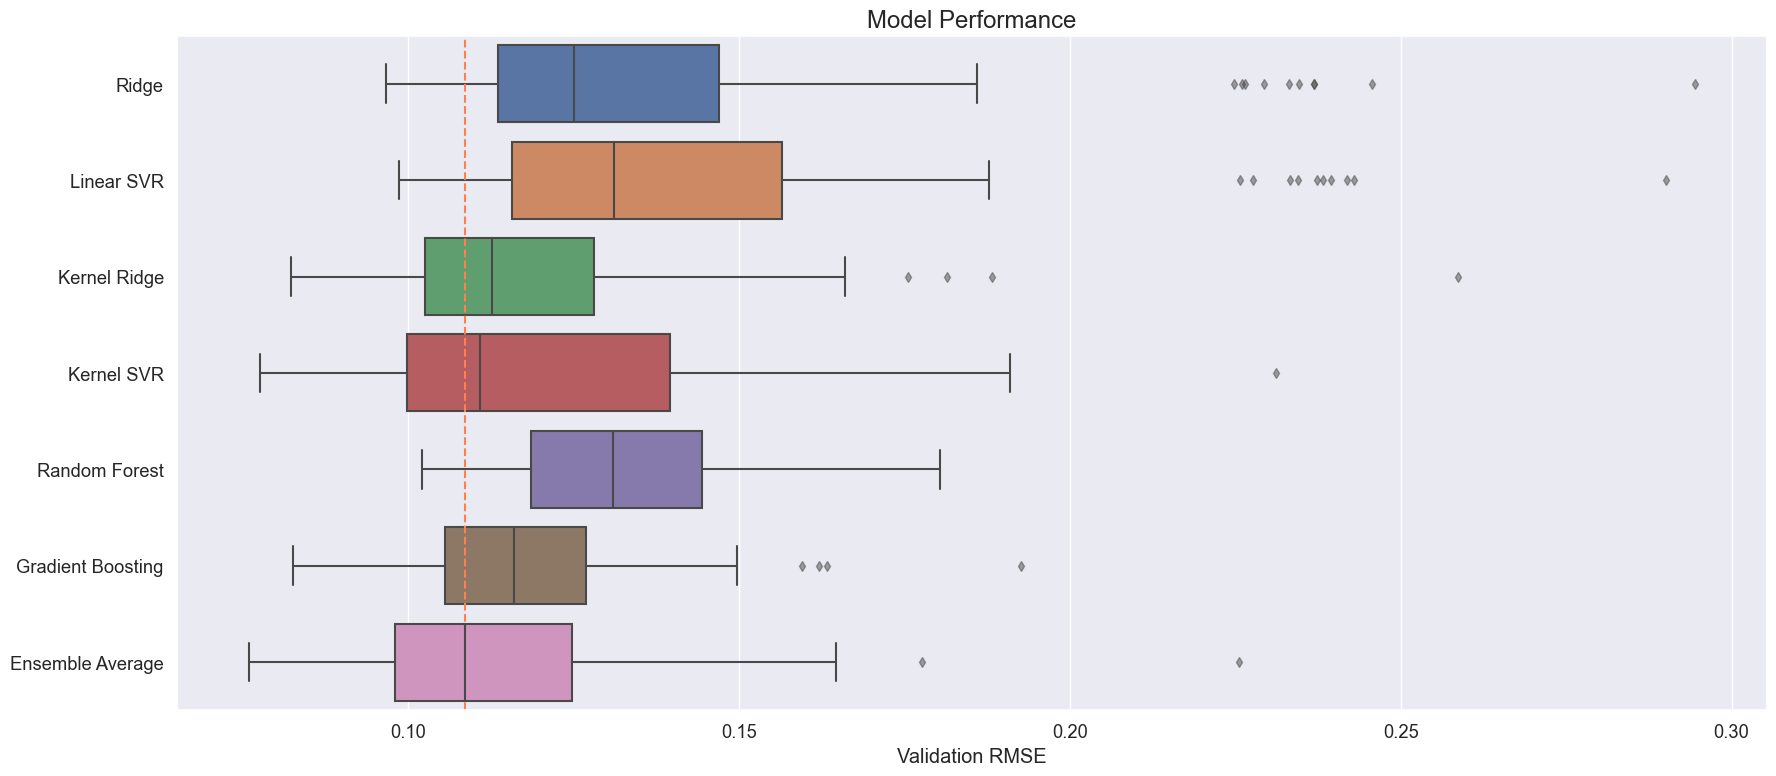

In [89]:
rkfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=SEED)

tuner.perf_boxplot(add_models=[("Ensemble Average", ensemble)], cv=rkfold)

---

# 5. Submission

We use the ensemble average as our final model.

In [90]:
submission = tuner.model_predict(ensemble, X_test)

submission.head()

,Id,SalePrice
0,1461,120100.126236
1,1462,162980.284142
2,1463,186550.542750
3,1464,200736.197544
4,1465,186745.636682


In [91]:
submission.to_csv("data/submission.csv", index=False)

---